# Consensus Clustering

## Purpose
The purpose of this step is to run consensus clustering.

## Input
- Cell-by-components matrix from the decompusition analysis.

## Output
- Adata file with cluster annotated.

## Import

In [1]:
import pathlib
import anndata
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ALLCools.clustering import ConsensusClustering, Dendrogram, get_pc_centers
from ALLCools.plot import *

## Parameters

In [2]:
# clustering name
clustering_name = 'L1'

# input data
cell_meta_path = './CellMetadata.PassQC.csv.gz'
adata_path = './adata.with_coords.mcad'
coord_base = 'tsne'

# ConsensusClustering
n_neighbors = 25
metric = 'euclidean'
min_cluster_size = 10
consensus_rate = 0.5
leiden_repeats = 500
leiden_resolution = 0.5
random_state = 0
n_jobs = 40
train_frac = 0.5
train_max_n = 500
max_iter = 20

# Dendrogram via Multiscale Bootstrap Resampling
nboot = 10000
method_dist = 'correlation'
method_hclust = 'average'

plot_type = 'static'

## Load Data

In [3]:
cell_meta = pd.read_csv(cell_meta_path, index_col=0)
adata = anndata.read_h5ad(adata_path)

## Consensus Clustering

In [4]:
cc = ConsensusClustering(model=None,
                         n_neighbors=n_neighbors,
                         metric=metric,
                         min_cluster_size=min_cluster_size,
                         leiden_repeats=leiden_repeats,
                         leiden_resolution=leiden_resolution,
                         consensus_rate=consensus_rate,
                         random_state=random_state,
                         train_frac=train_frac,
                         train_max_n=train_max_n,
                         max_iter=max_iter,
                         n_jobs=n_jobs)

In [5]:
if 'X_pca' not in adata.obsm:
    raise KeyError(
        'X_pca do not exist in the adata file, run PCA first before clustering.'
    )
cc.fit_predict(adata.obsm['X_pca'])

Computing nearest neighbor graph
Computing multiple clustering with different random seeds
Repeating leiden clustering 500 times
Found 10 - 12 clusters, mean 10.8, std 0.43
Summarizing multiple clustering results
2631 cells assigned to 24 raw clusters
125 cells are multi-leiden outliers

=== Start supervise model training and cluster merging ===

=== iteration 1 ===
24 non-outlier labels
Balanced accuracy on the training set: 0.969
Balanced accuracy on the hold-out set: 0.823
Distance between 20 - 18: 0.004 < 0.500
Merging 1 clusters.

=== iteration 2 ===
23 non-outlier labels
Balanced accuracy on the training set: 0.971
Balanced accuracy on the hold-out set: 0.859
Distance between 15 - 0: 0.006 < 0.500
Merging 1 clusters.

=== iteration 3 ===
22 non-outlier labels
Balanced accuracy on the training set: 0.970
Balanced accuracy on the hold-out set: 0.861
Distance between 20 - 0: 0.028 < 0.500
Distance between 7 - 0: 0.022 < 0.500
Merging 2 clusters.

=== iteration 4 ===
20 non-outlier l

## Plot ConsensusClustering Details

### Individual Leiden runs with different random states

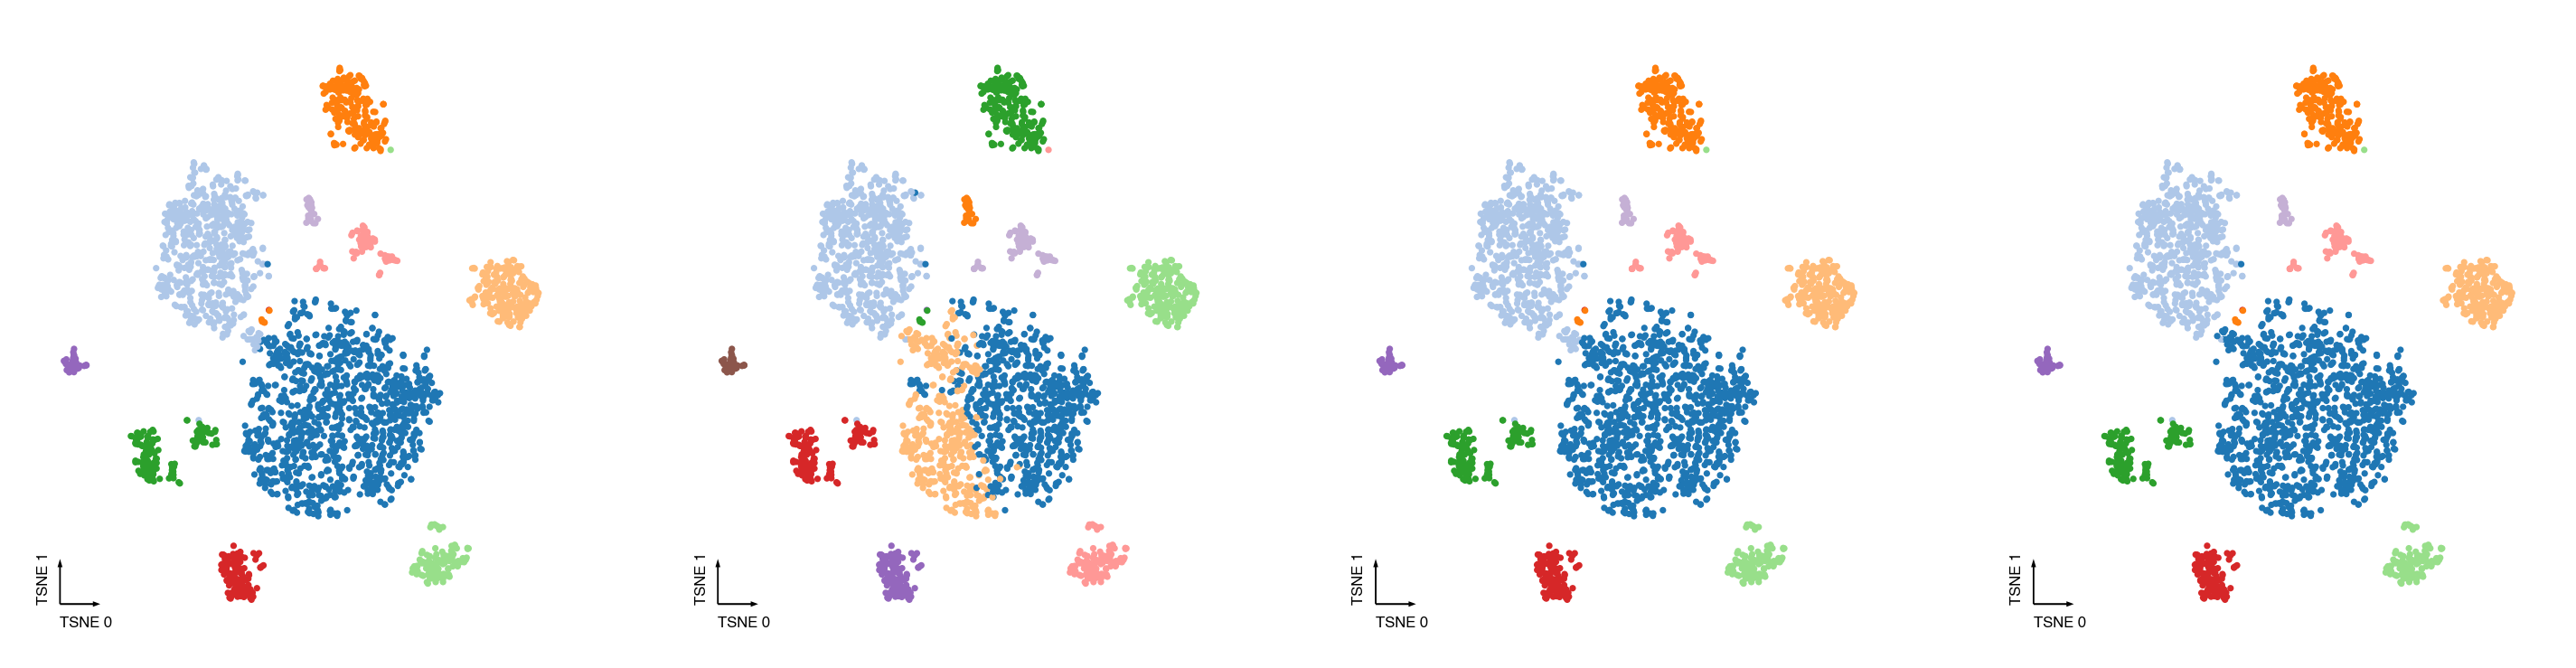

In [6]:
fig, axes = cc.plot_leiden_cases(coord_data=adata.obs,
                                 coord_base=coord_base)

### Merging steps

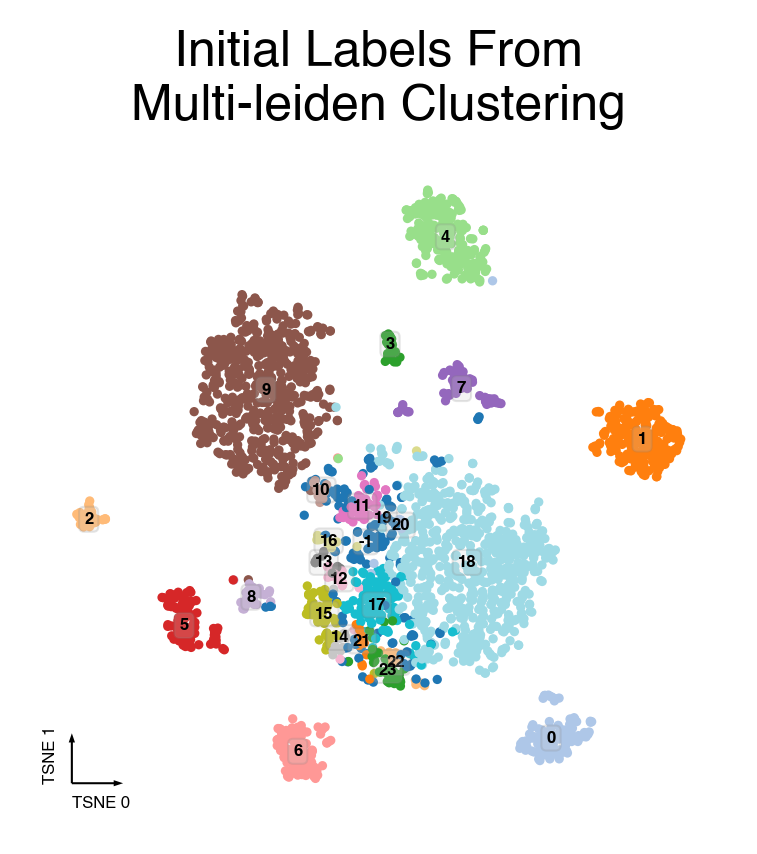

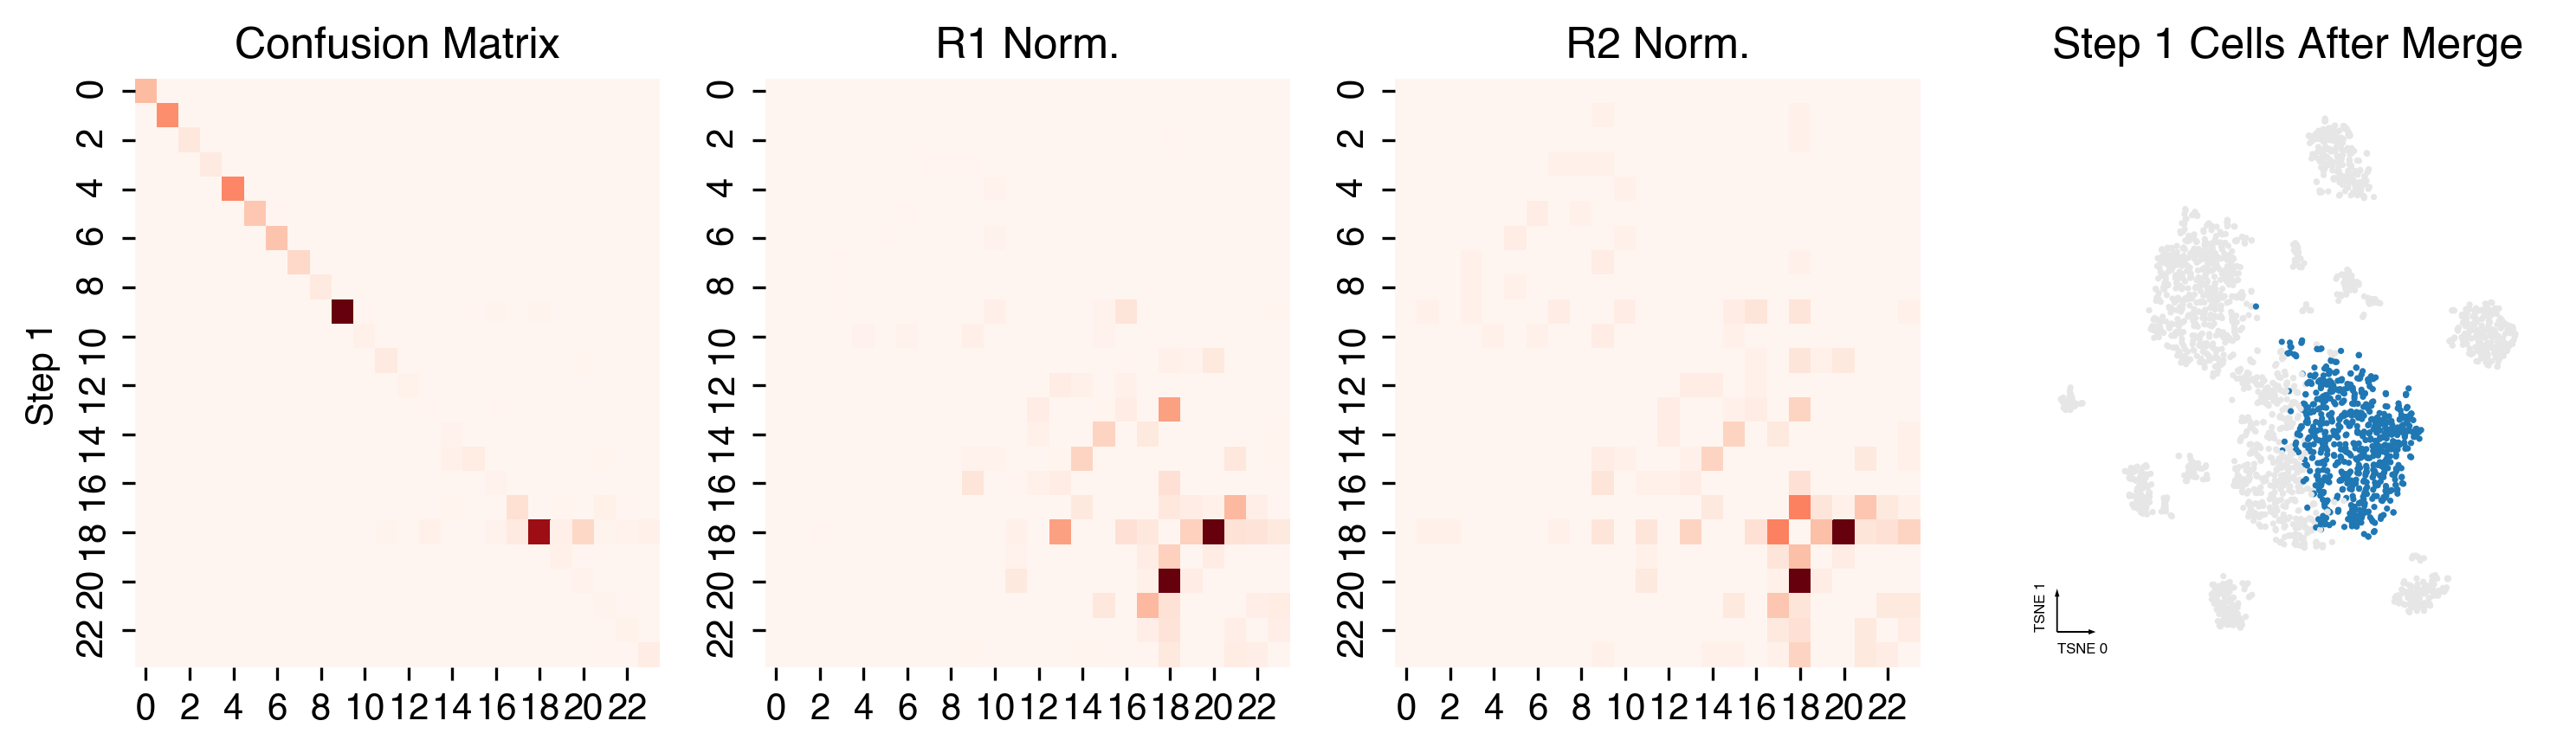

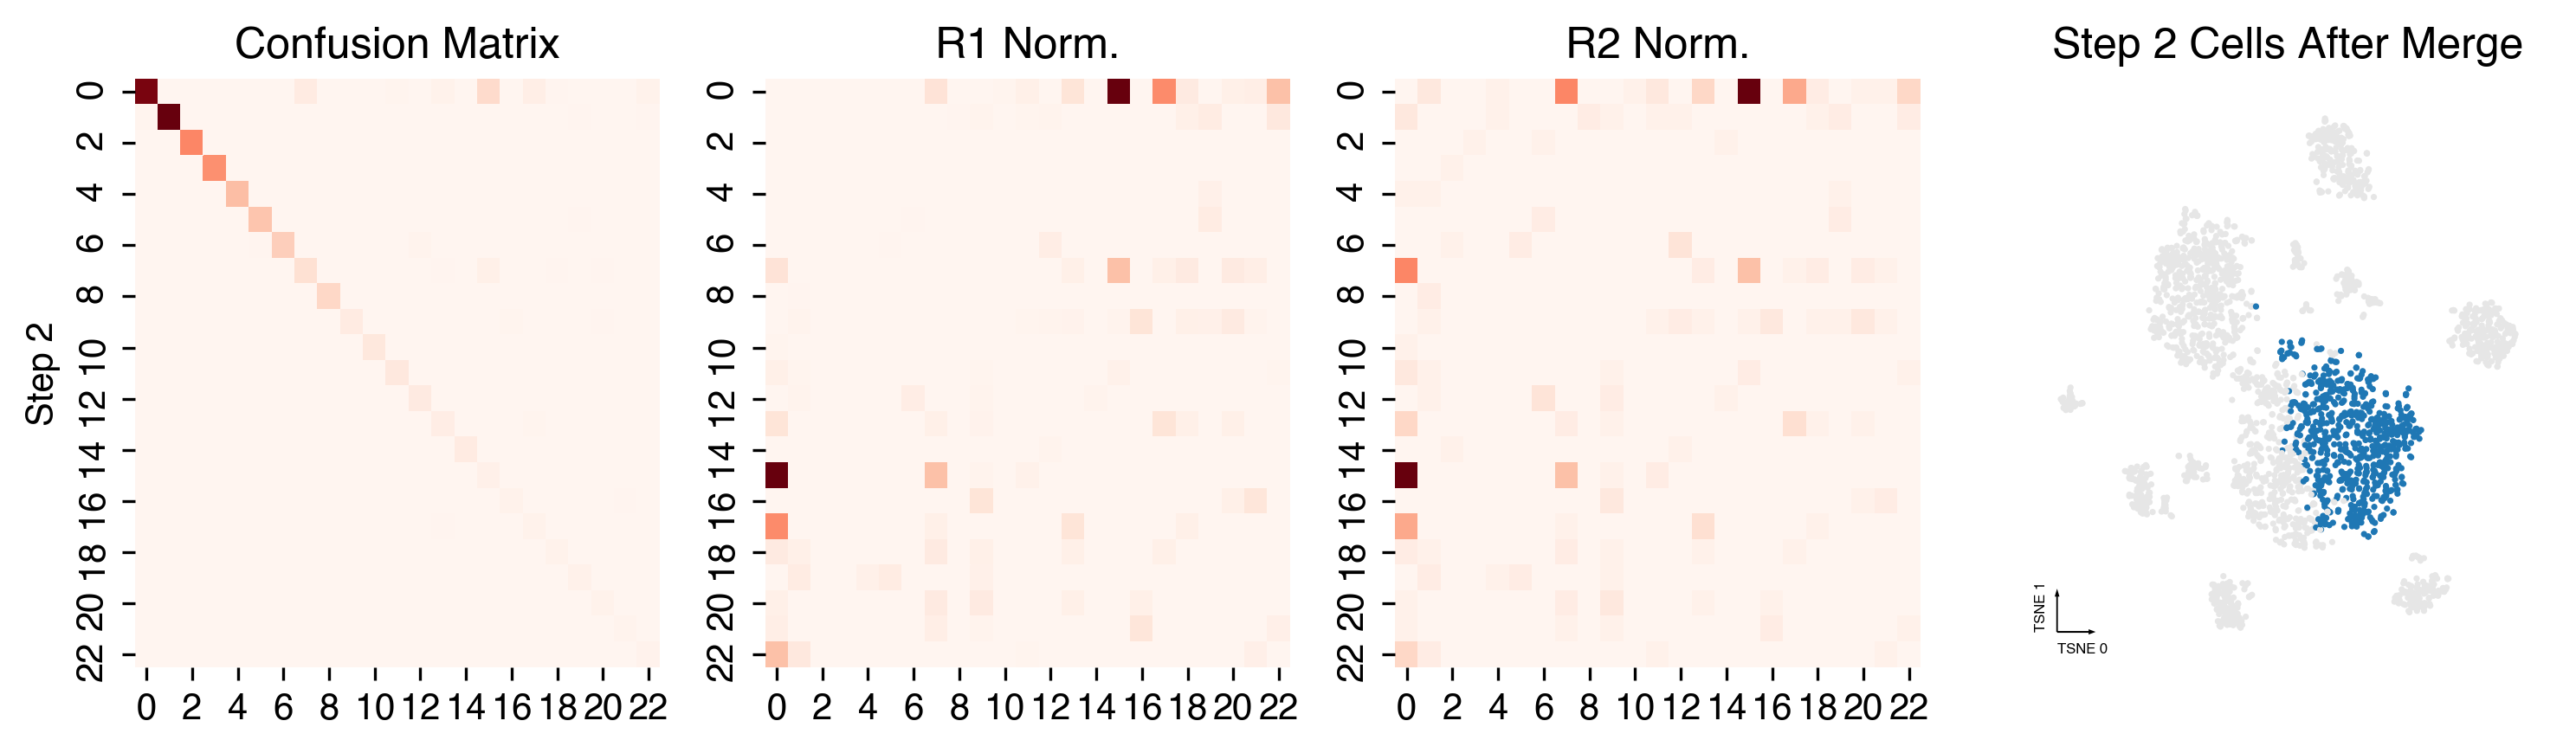

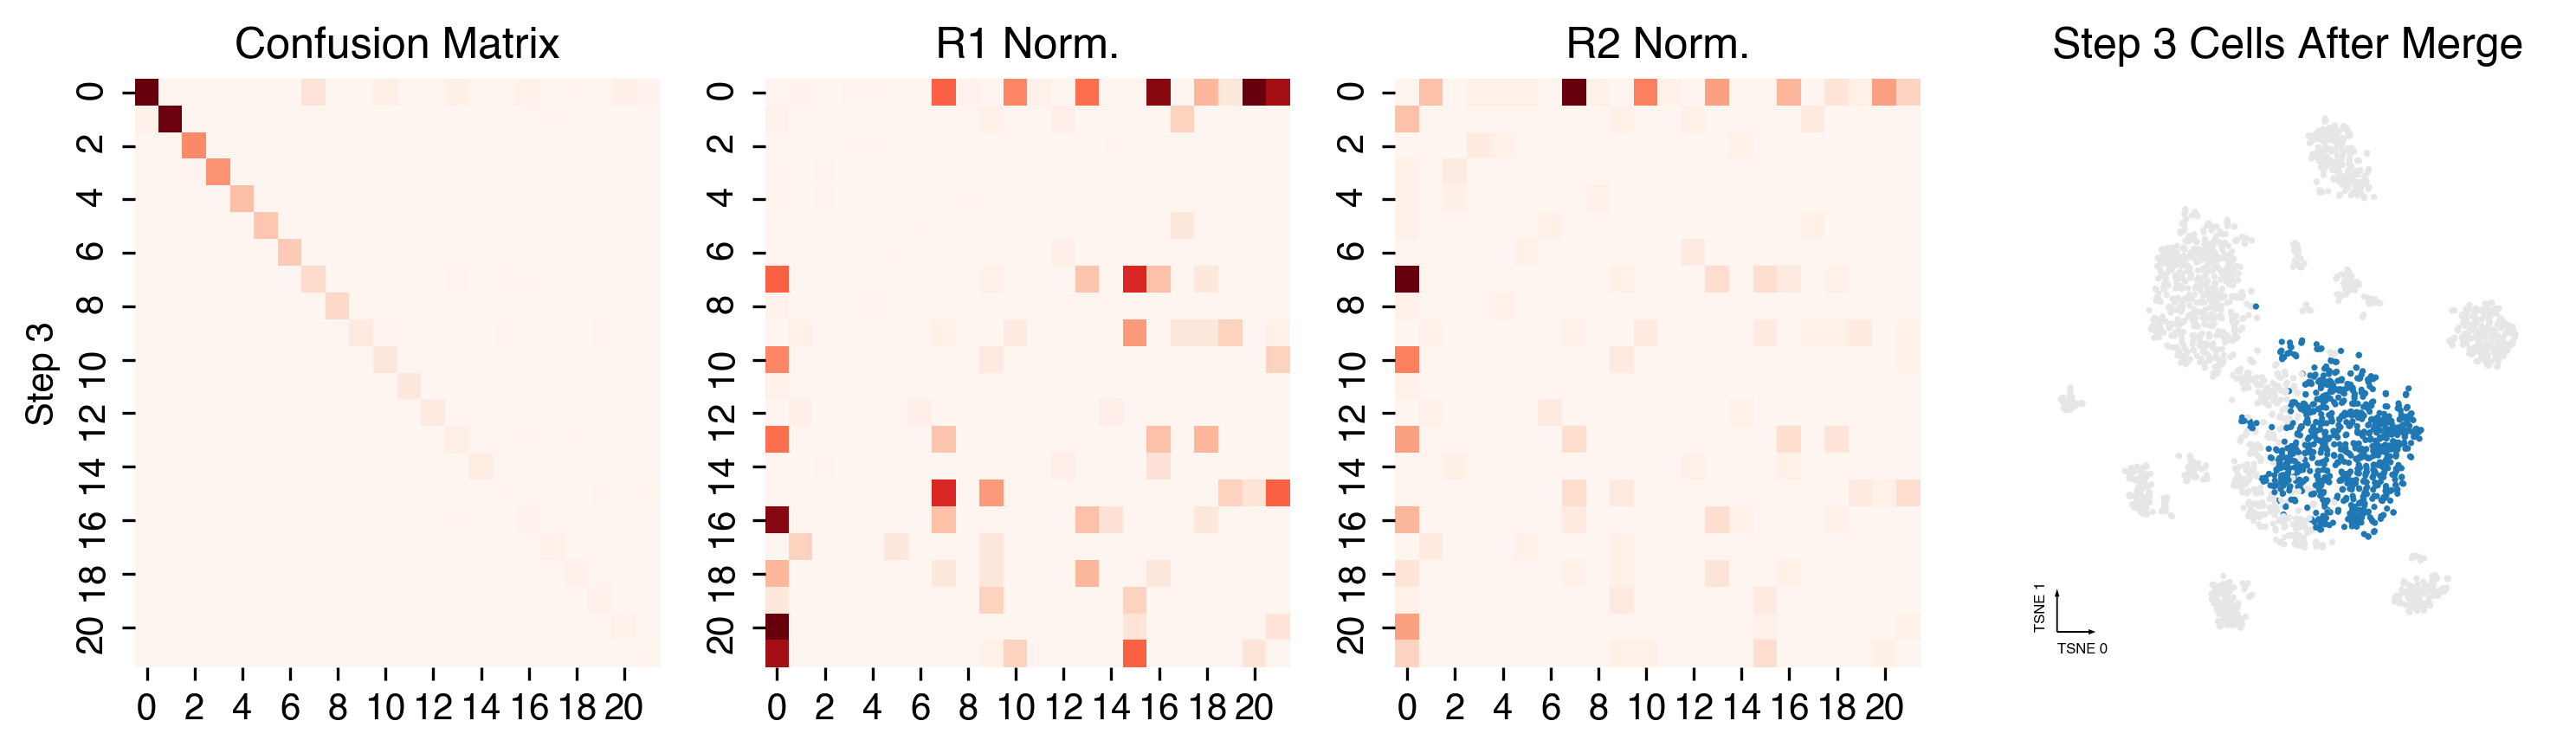

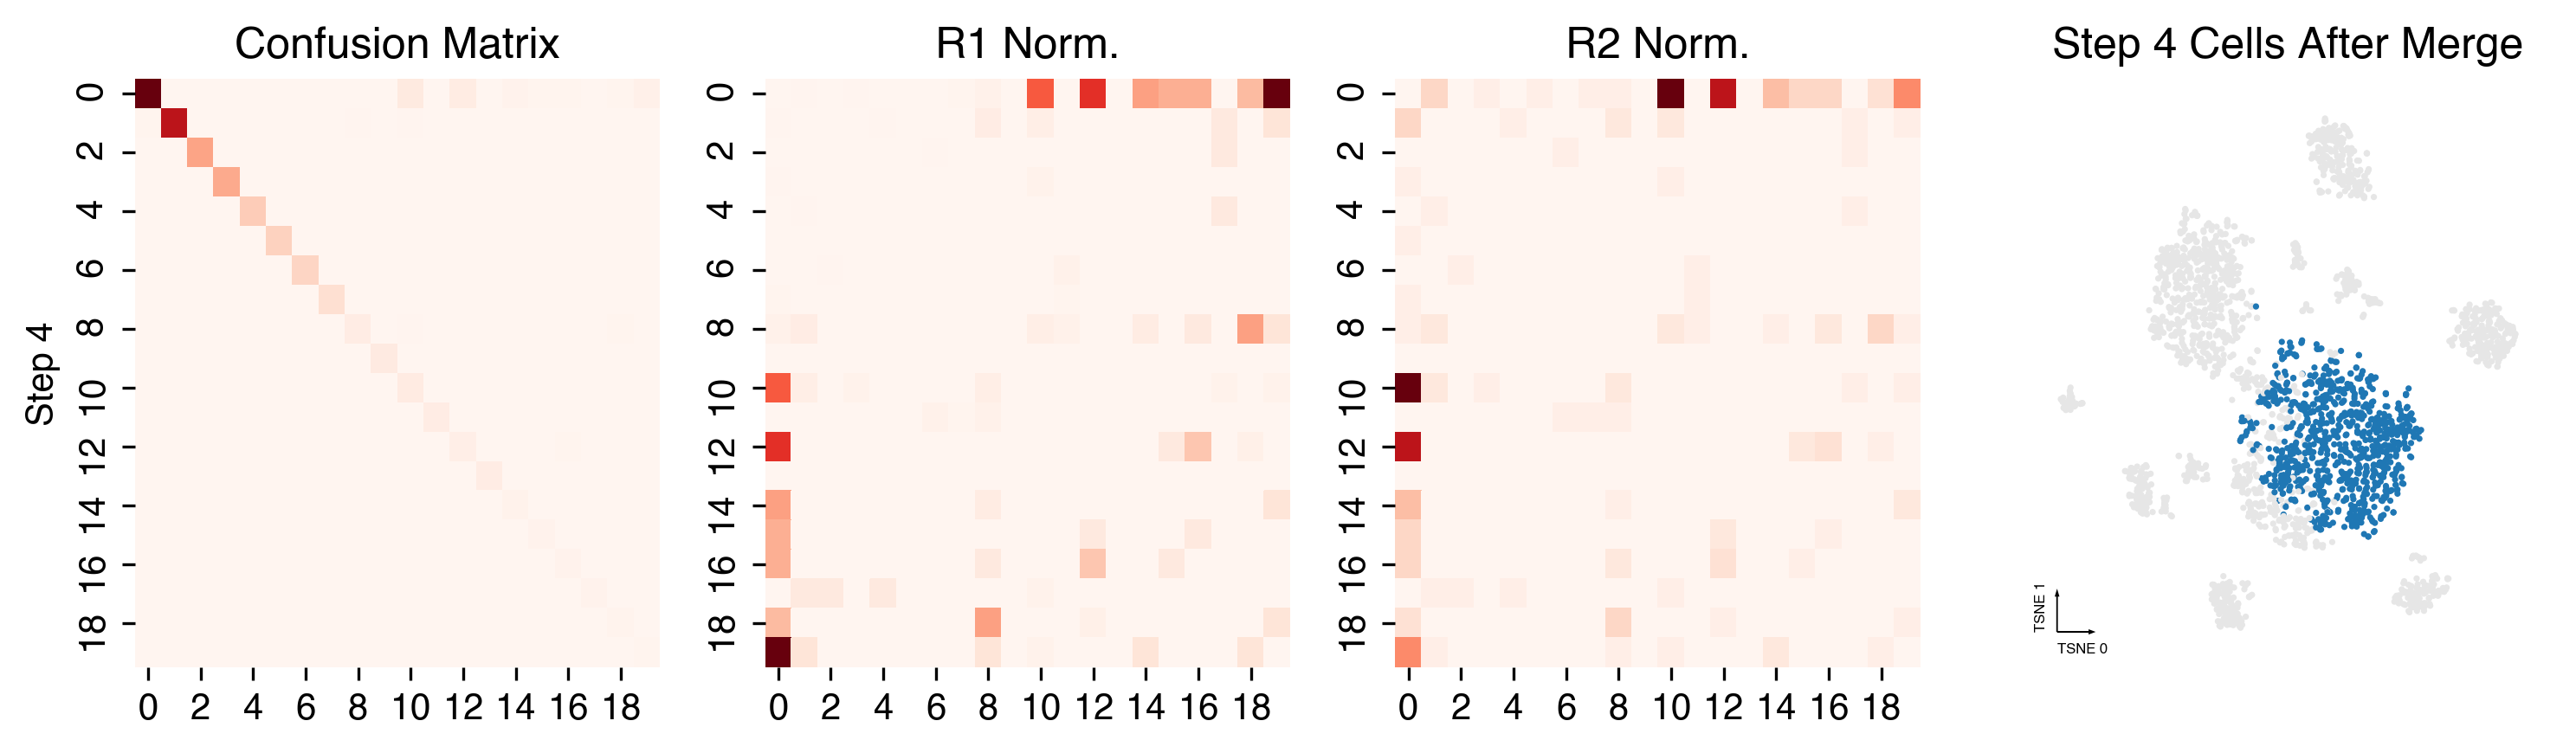

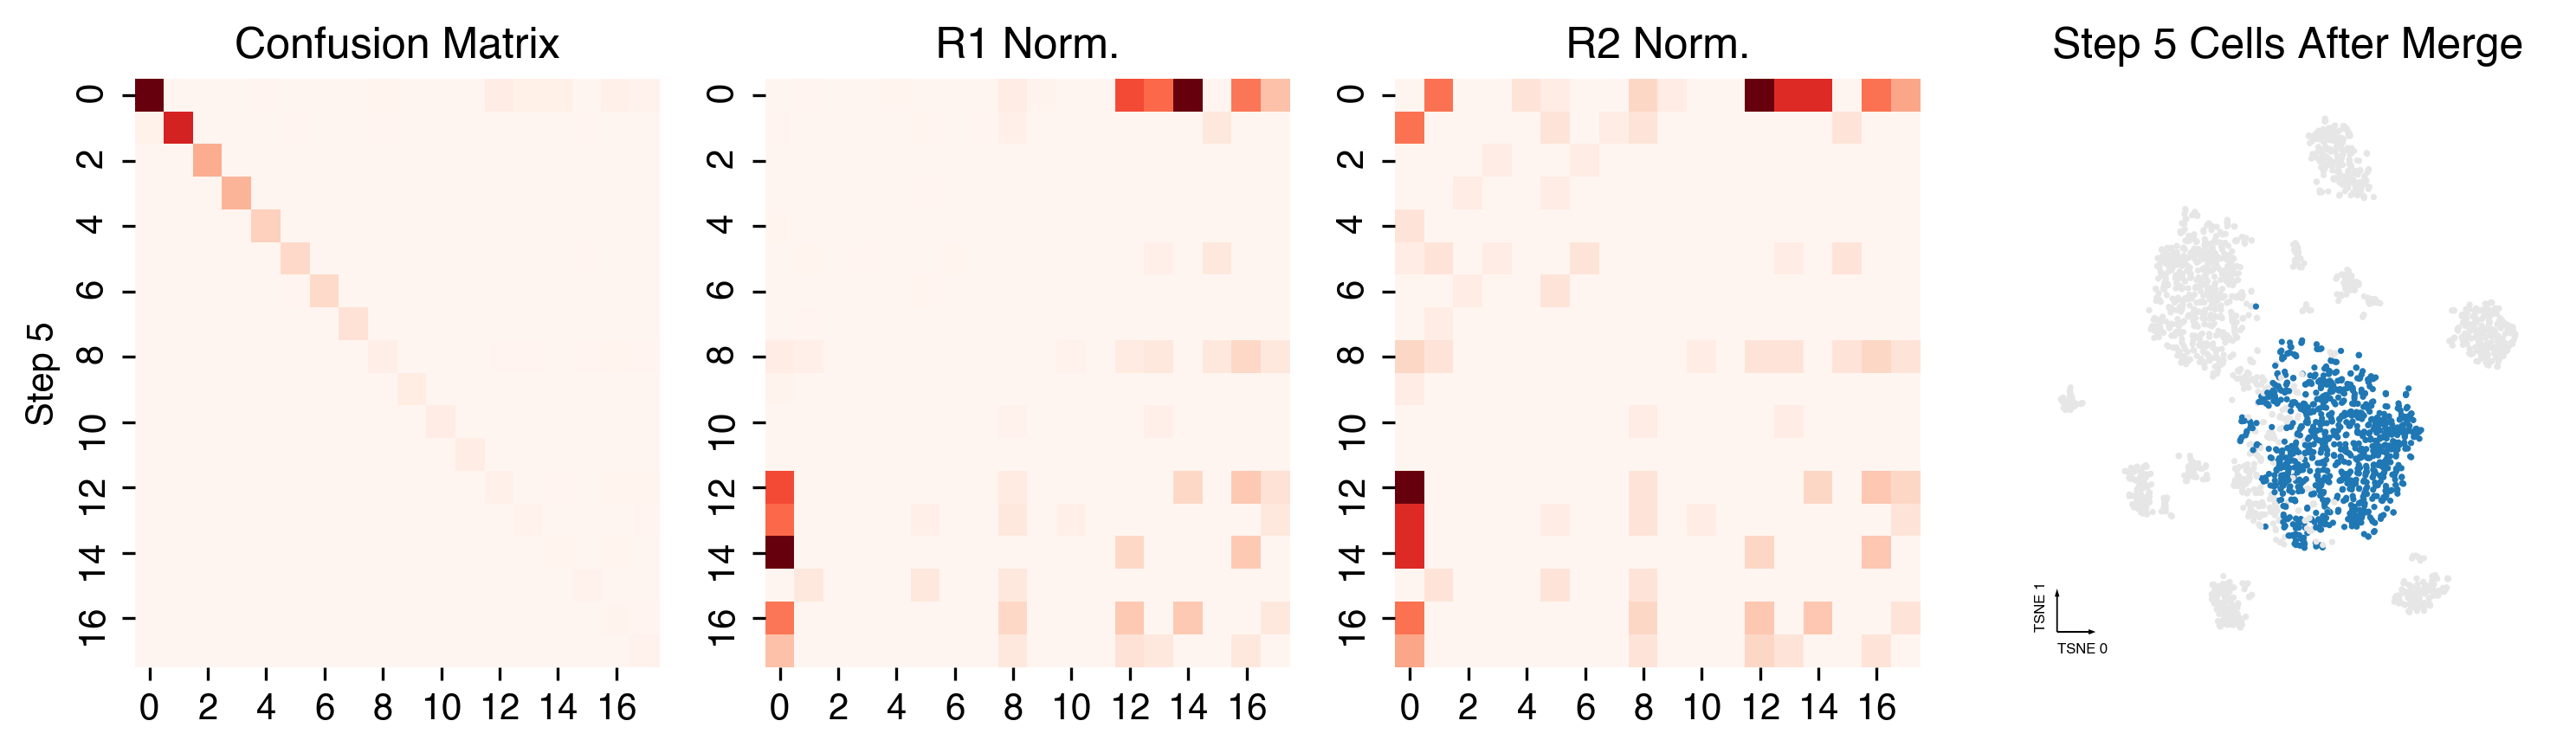

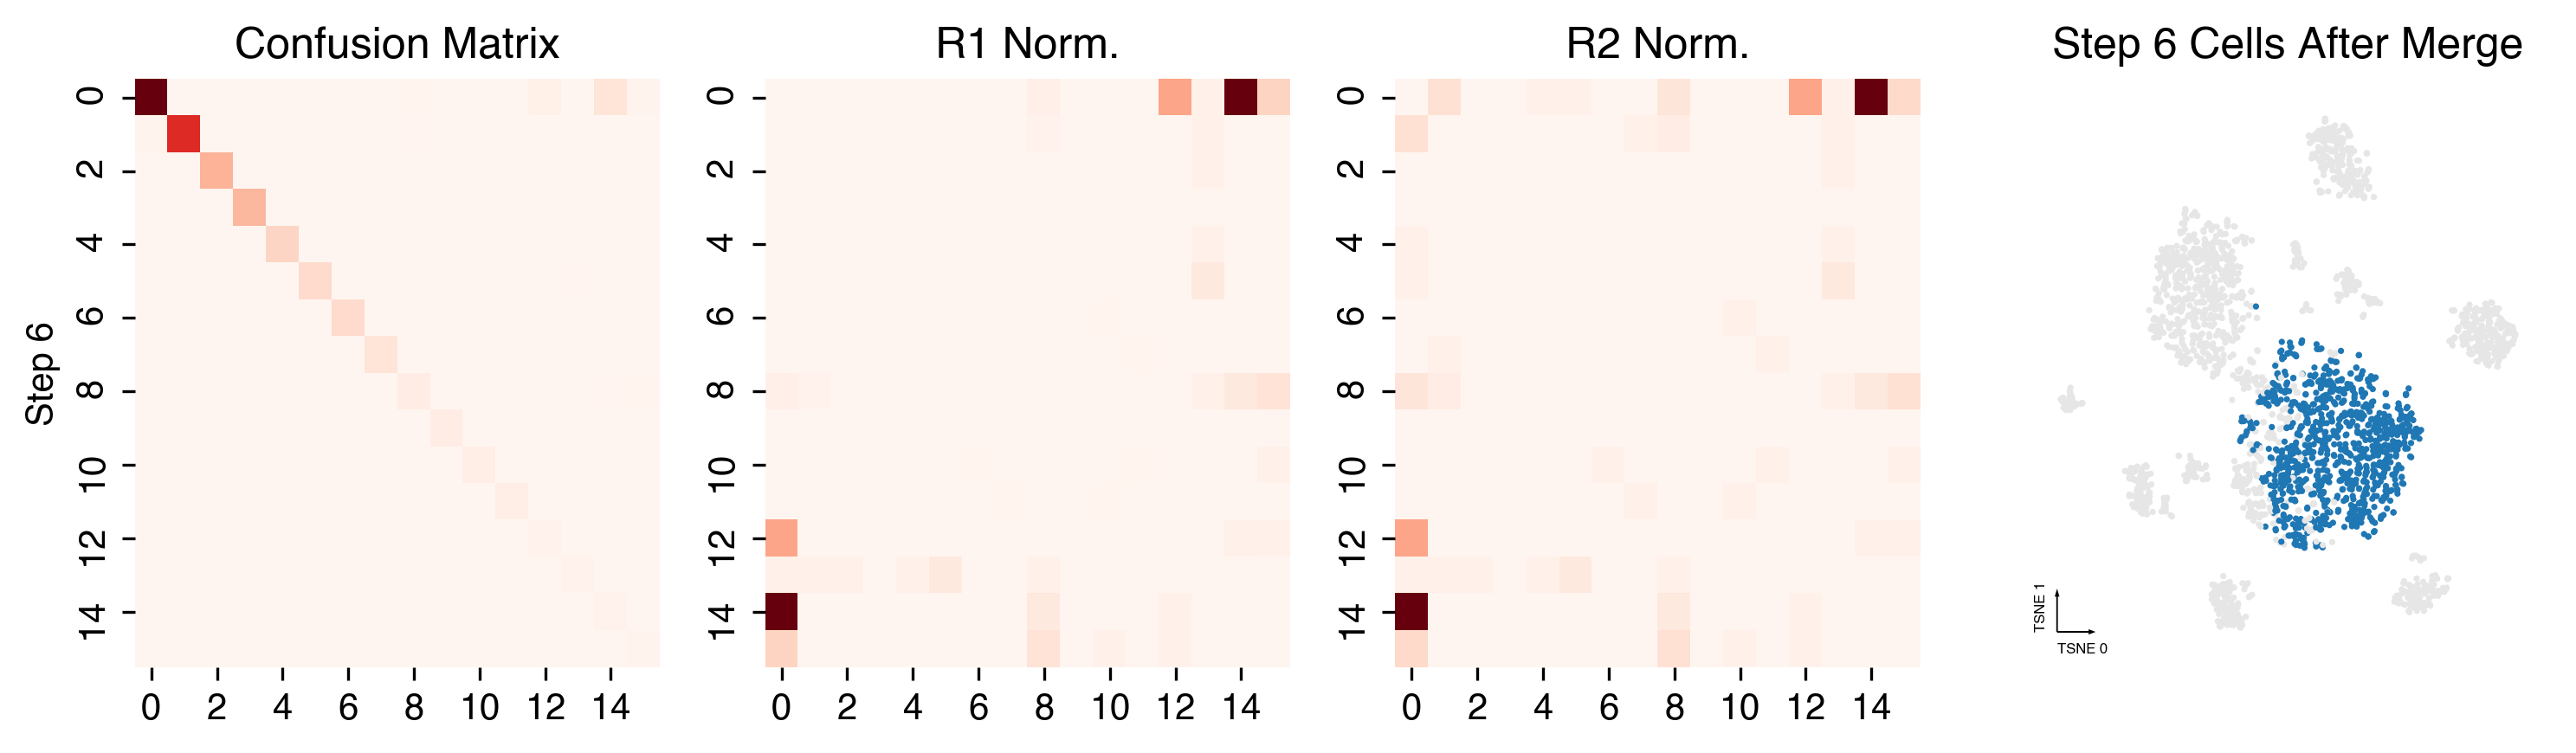

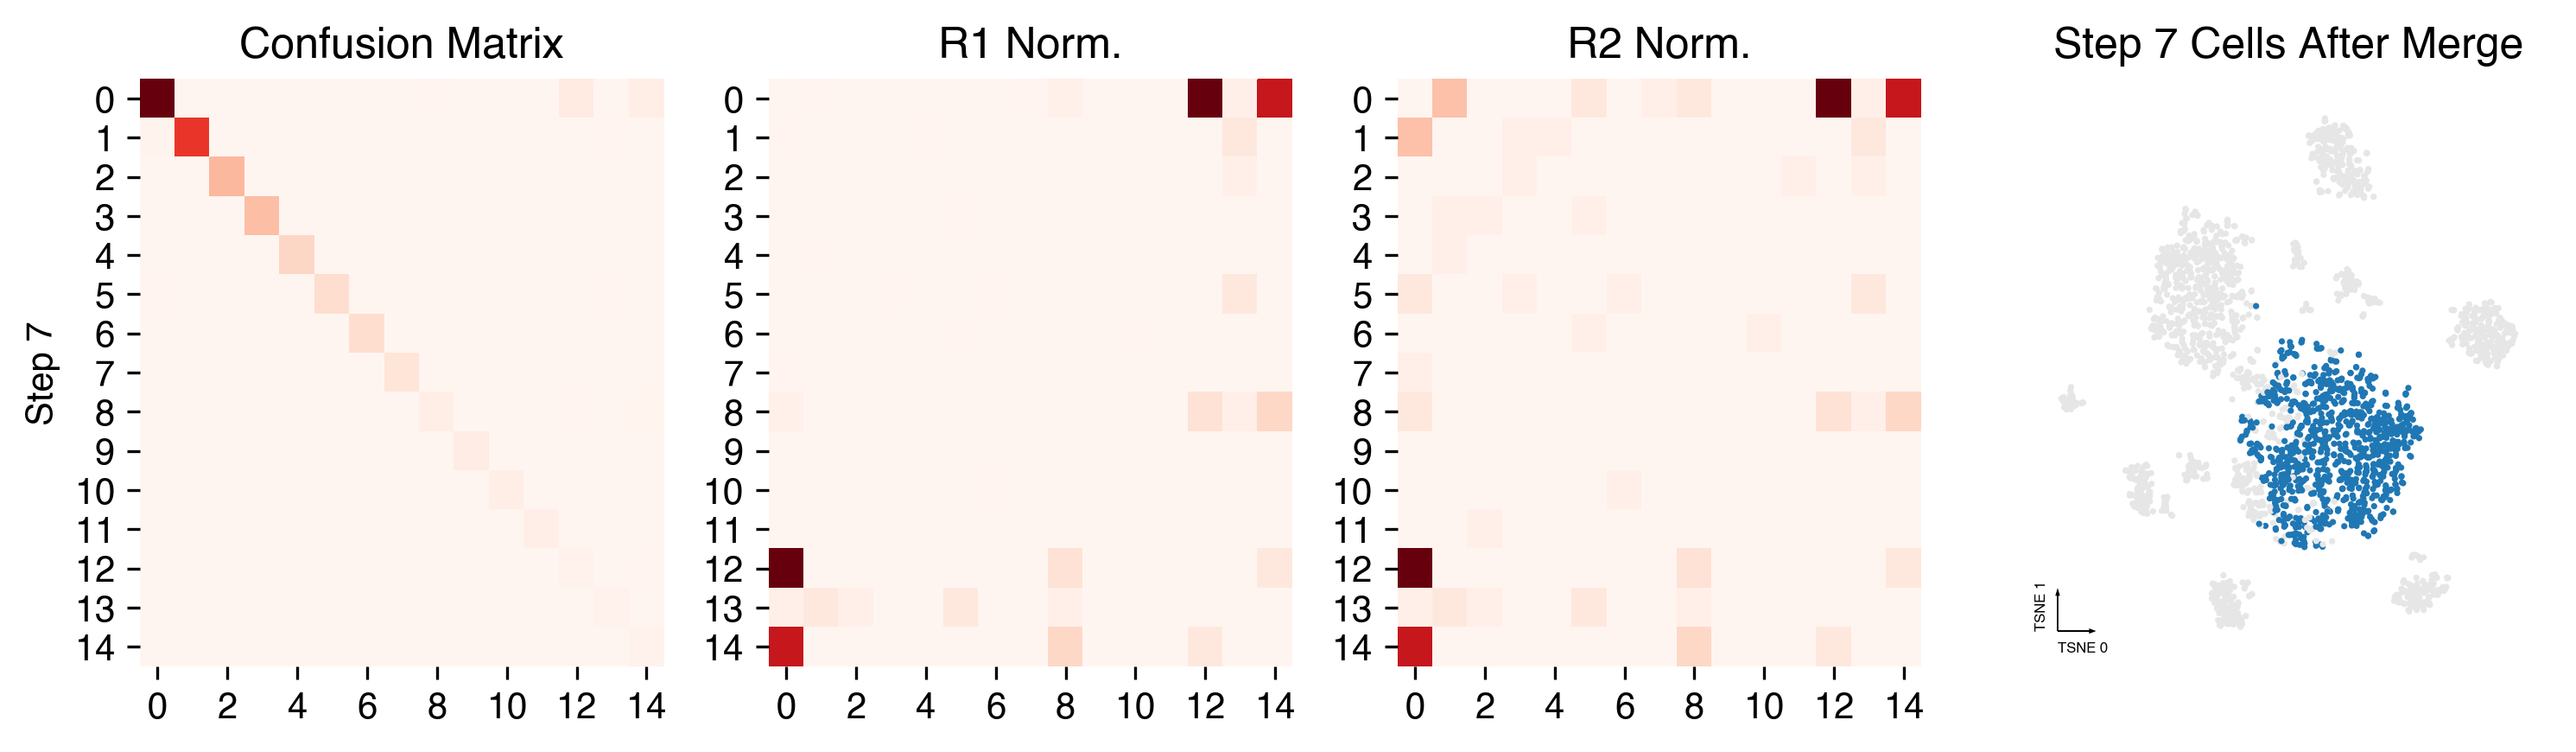

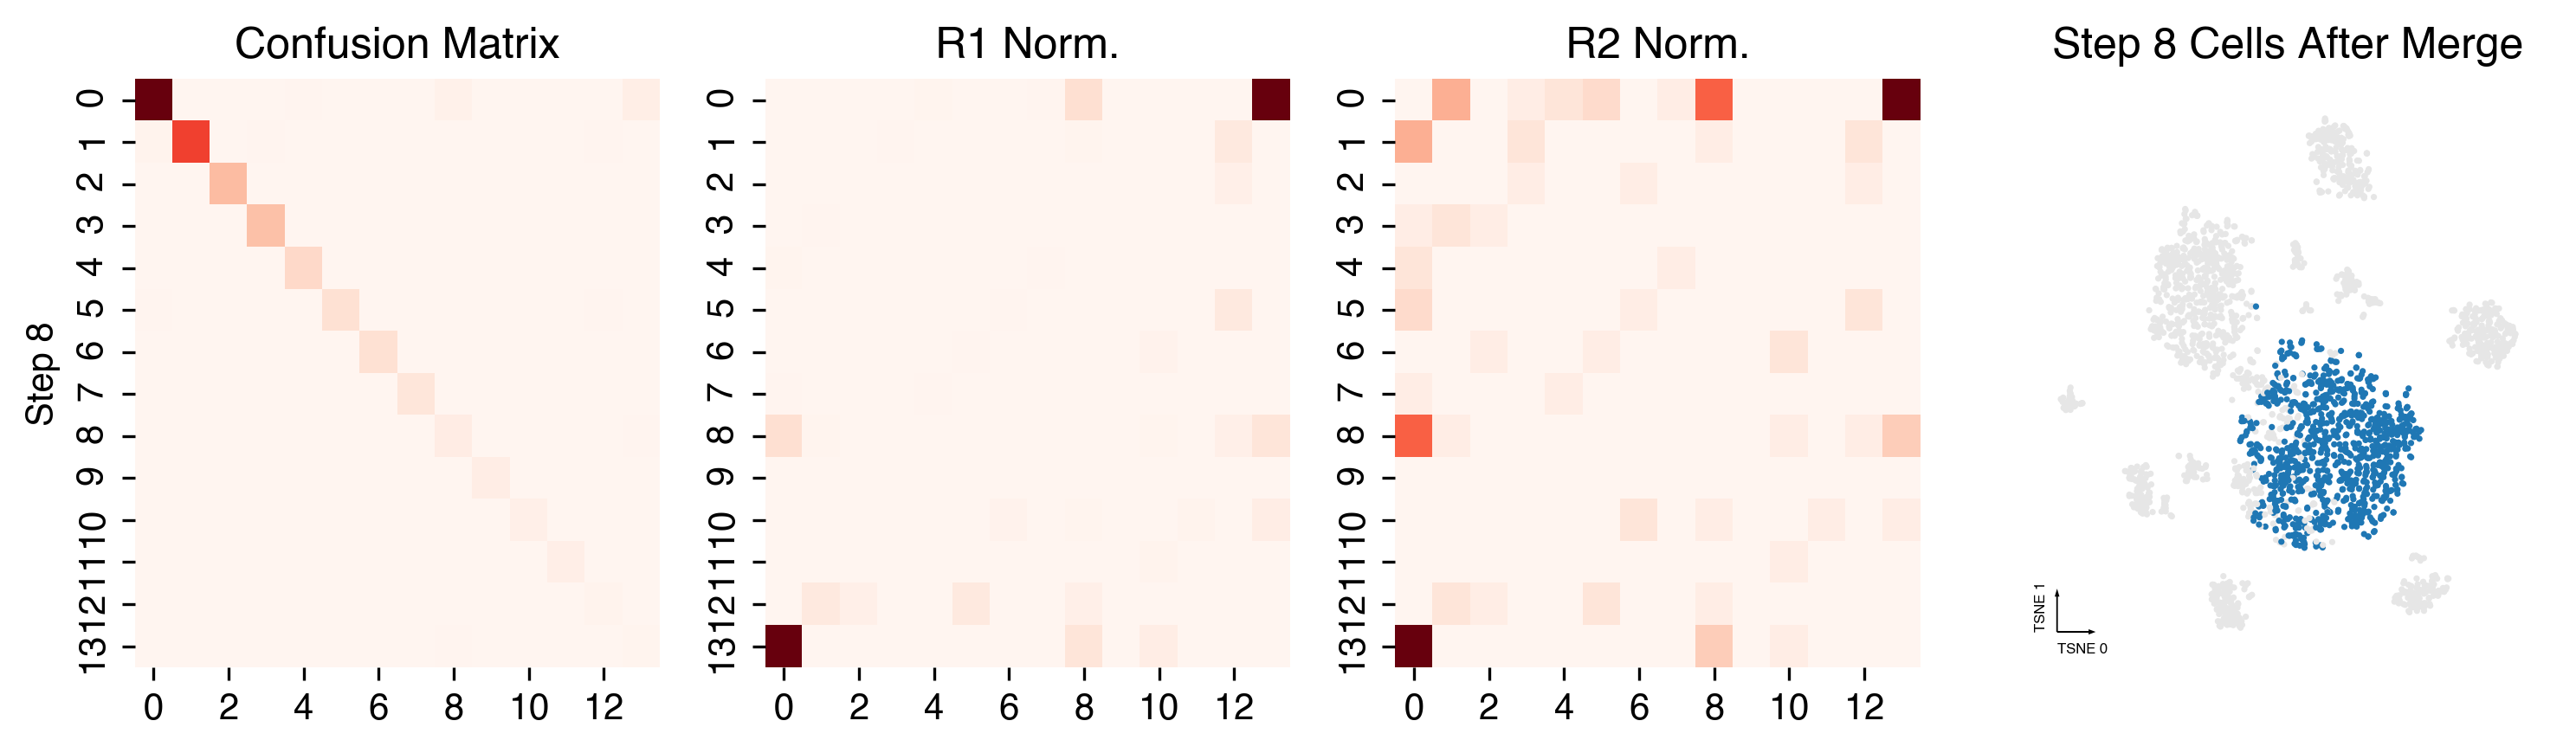

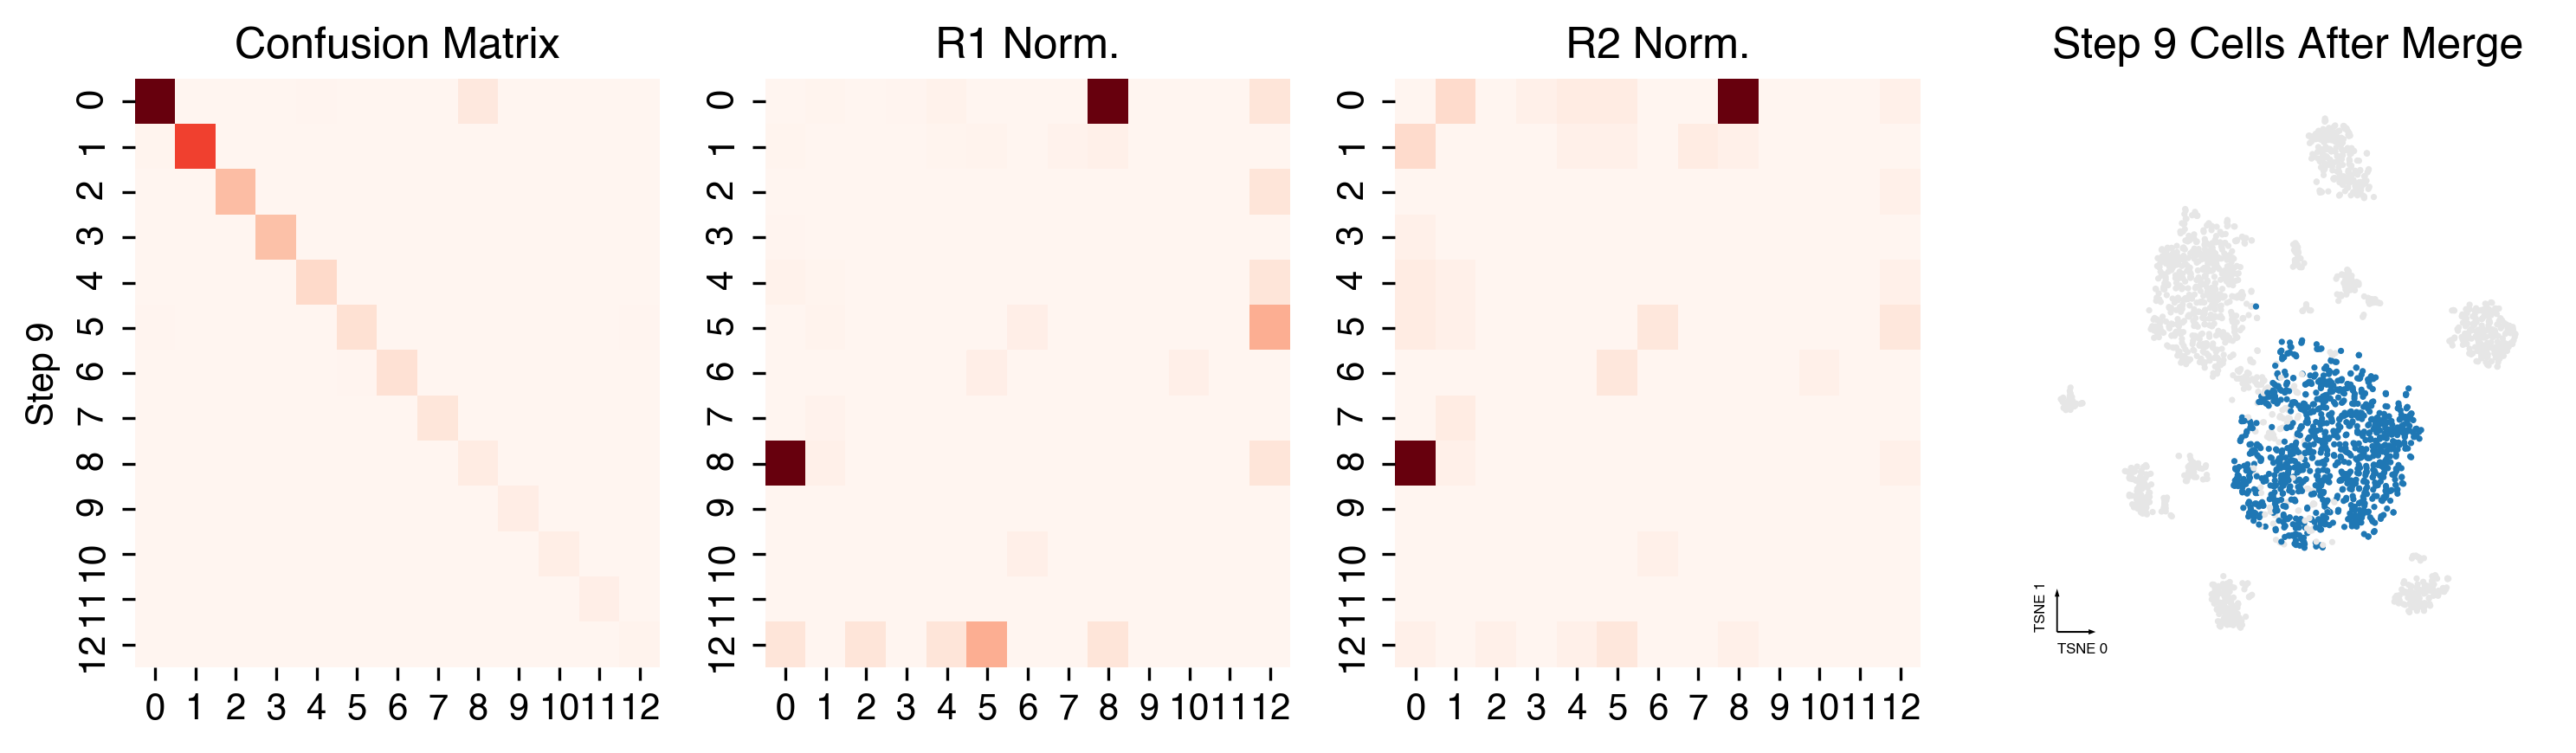

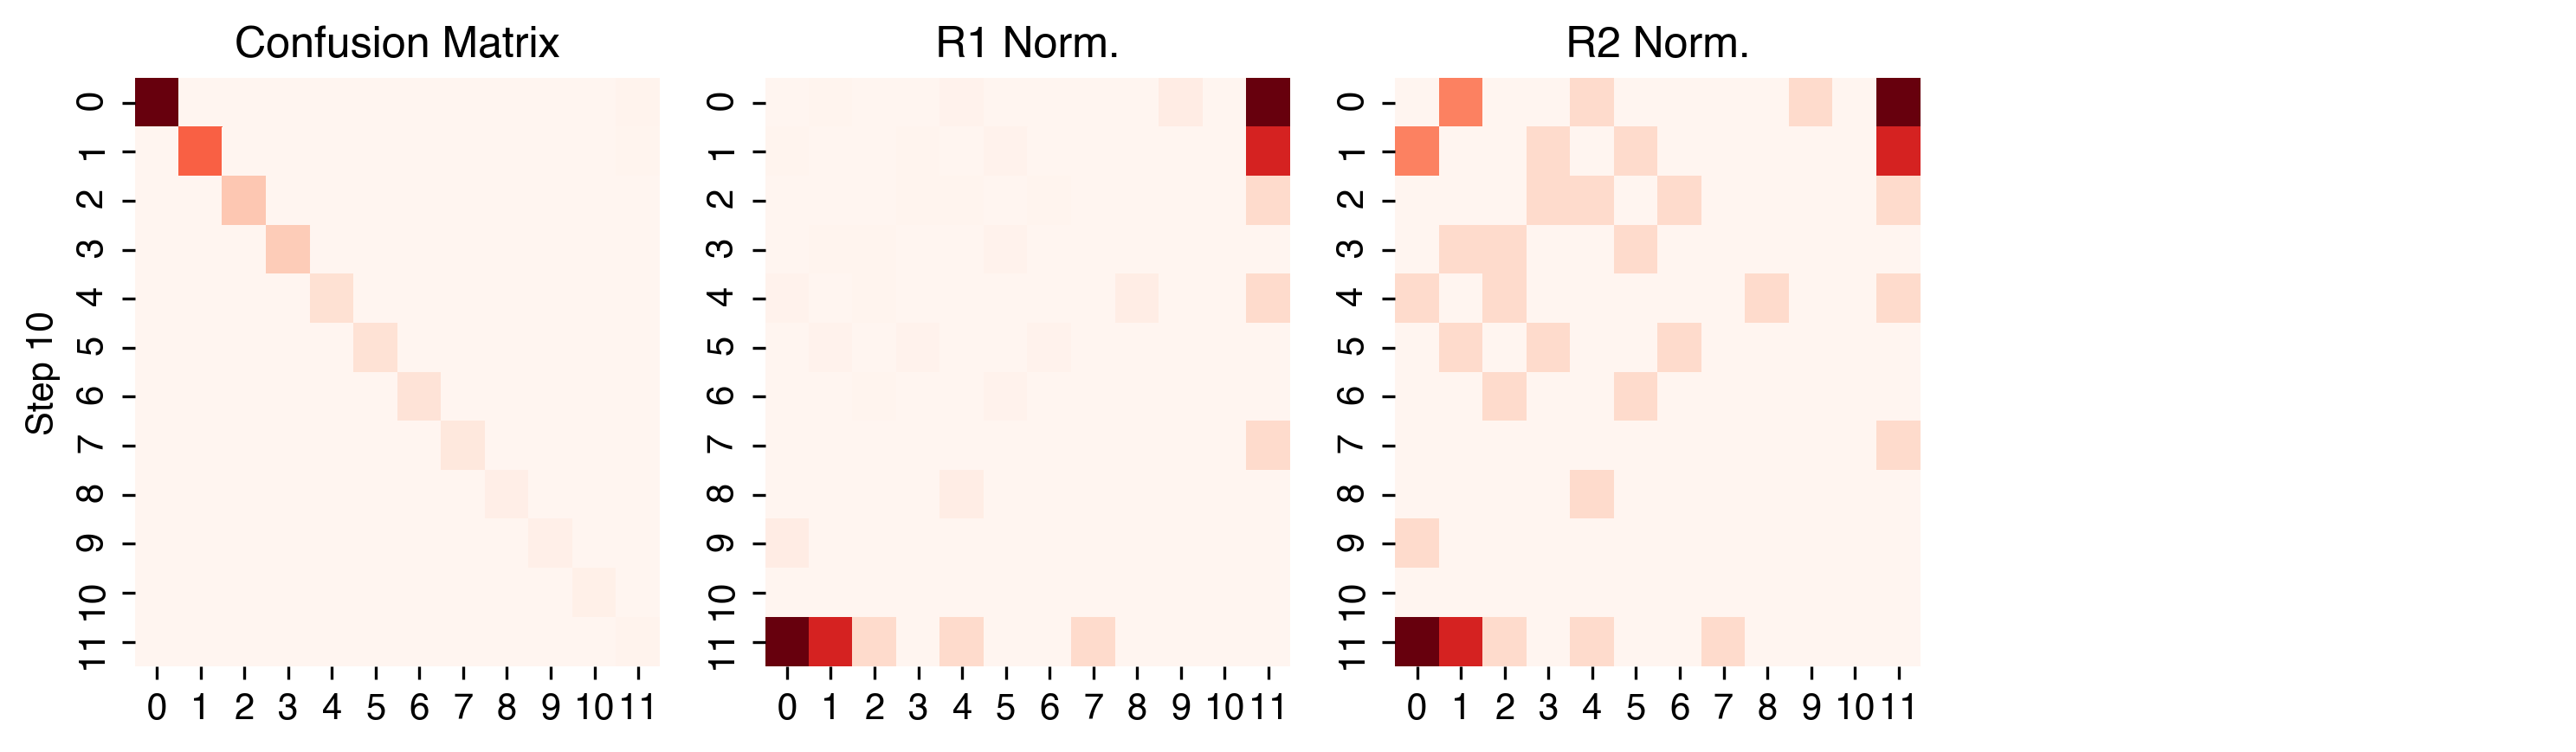

In [7]:
cc.plot_steps(coord_data=adata.obs, coord_base=coord_base)

## Plot Final Clustering Results

### Cluster Lables

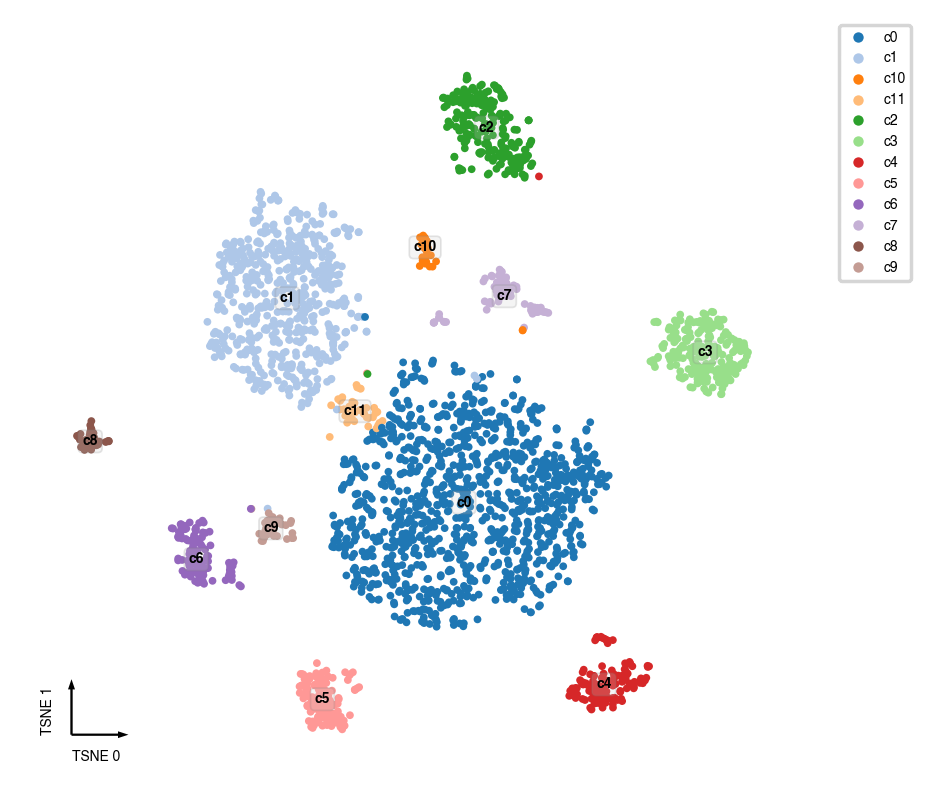

In [8]:
adata.obs[clustering_name] = cc.label

fig, ax = plt.subplots(figsize=(4, 4), dpi=250)
_ = categorical_scatter(data=adata.obs,
                        ax=ax,
                        hue=clustering_name,
                        coord_base=coord_base,
                        palette='tab20',
                        text_anno=clustering_name,
                        show_legend=True)

### Final Prediction Probability

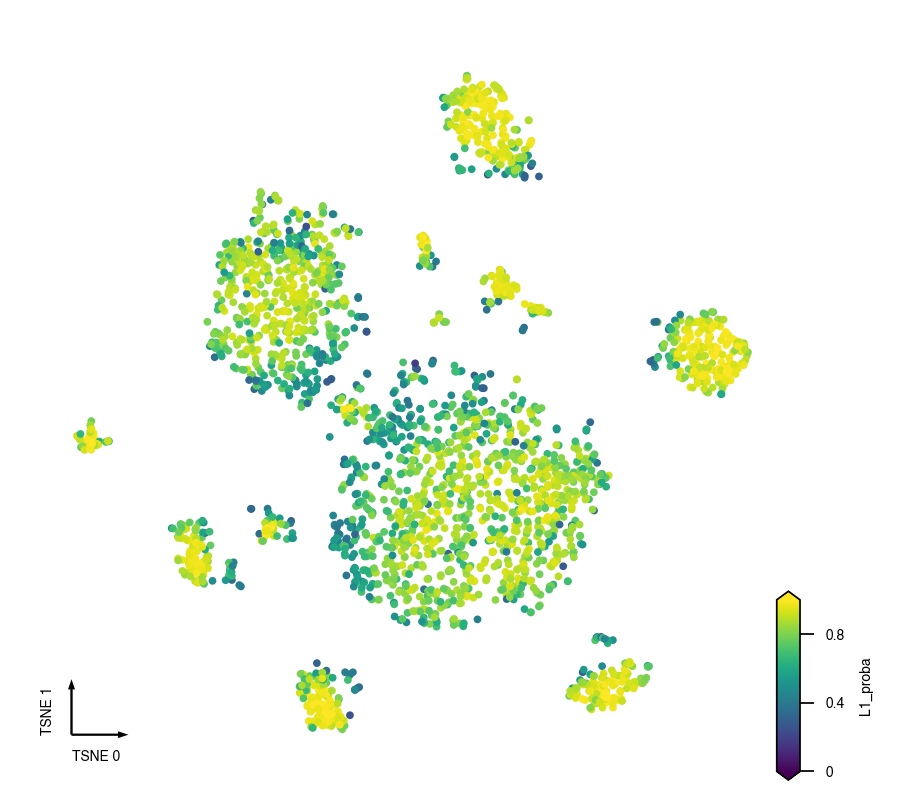

In [9]:
adata.obs[clustering_name + '_proba'] = cc.label_proba

fig, ax = plt.subplots(figsize=(4, 4), dpi=250)
_ = continuous_scatter(data=adata.obs,
                       ax=ax,
                       hue_norm=(0, 1),
                       hue=clustering_name + '_proba',
                       coord_base=coord_base)

### Prediction Probability Per Cluster

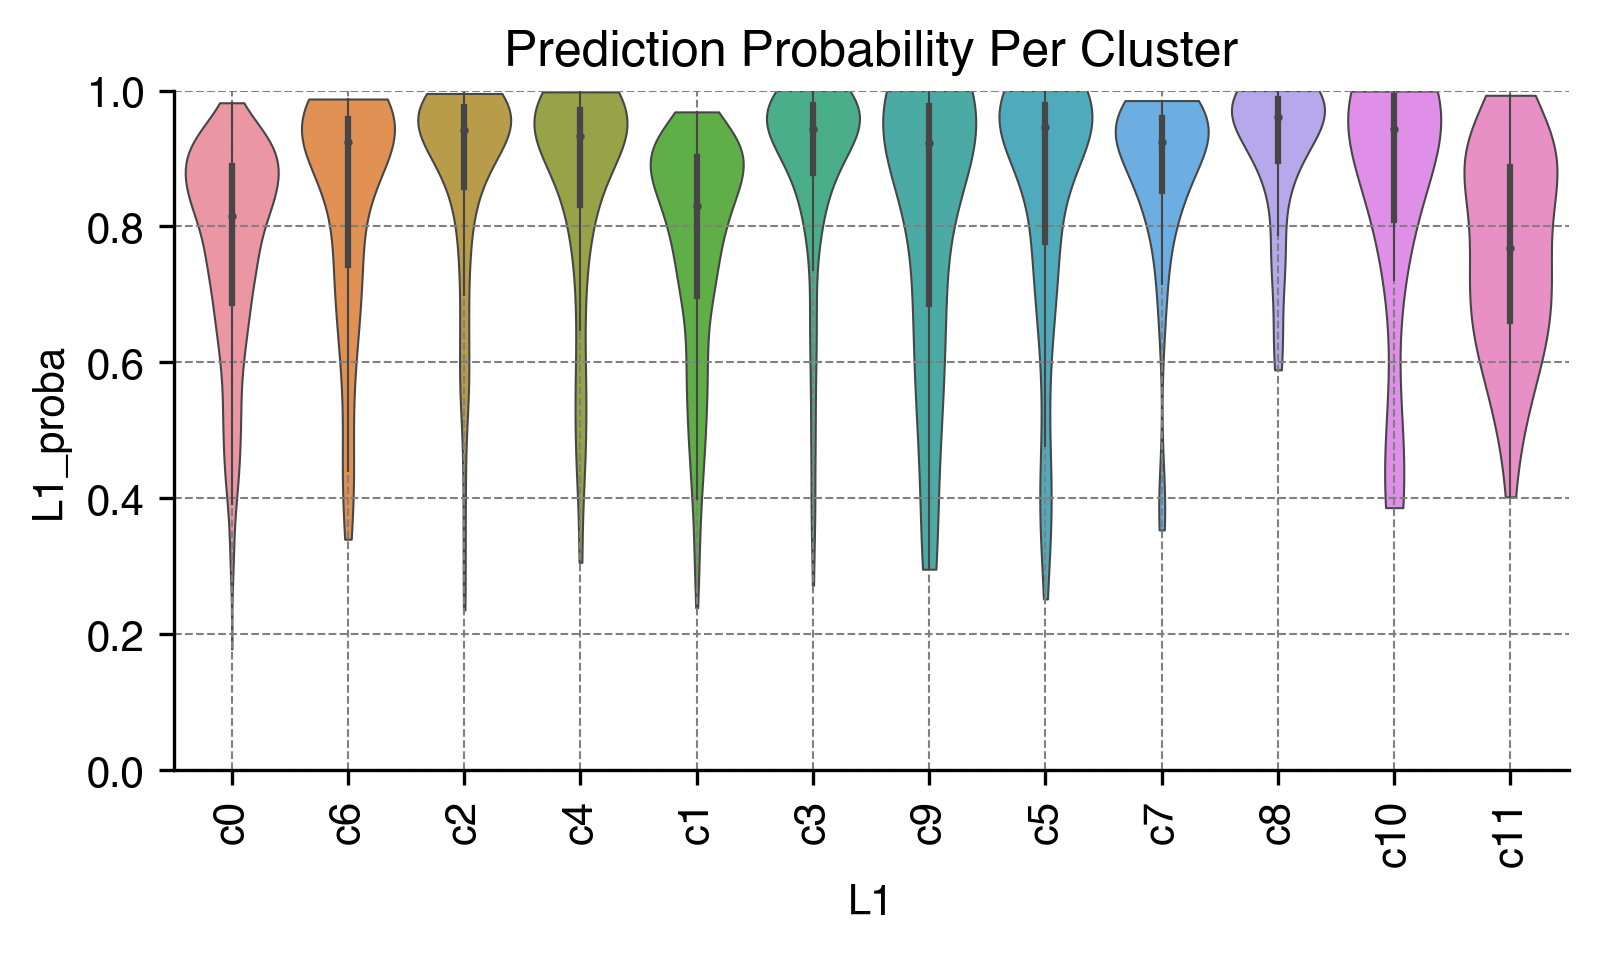

In [10]:
fig, ax = plt.subplots(figsize=(6, 3), dpi=300)

sns.violinplot(data=adata.obs,
               x=clustering_name,
               y=clustering_name + '_proba',
               scale='width',
               linewidth=0.5,
               cut=0,
               ax=ax)
ax.set(ylim=(0, 1), title='Prediction Probability Per Cluster')
ax.xaxis.set_tick_params(rotation=90)
ax.grid(linewidth=0.5, color='gray', linestyle='--')
sns.despine(ax=ax)

## Calculate Cluster Dendrogram

In [11]:
# using the cluster centroids in PC space to calculate dendrogram
pc_center = get_pc_centers(adata, group=clustering_name)

# calculate the cluster dendrogram using R package pvclust
dendro = Dendrogram(nboot=nboot,
                    method_dist=method_dist,
                    method_hclust=method_hclust,
                    n_jobs=n_jobs)
dendro.fit(pc_center)

Creating a temporary cluster...done:
socket cluster with 40 nodes on host ‘localhost’
Multiscale bootstrap... Done.


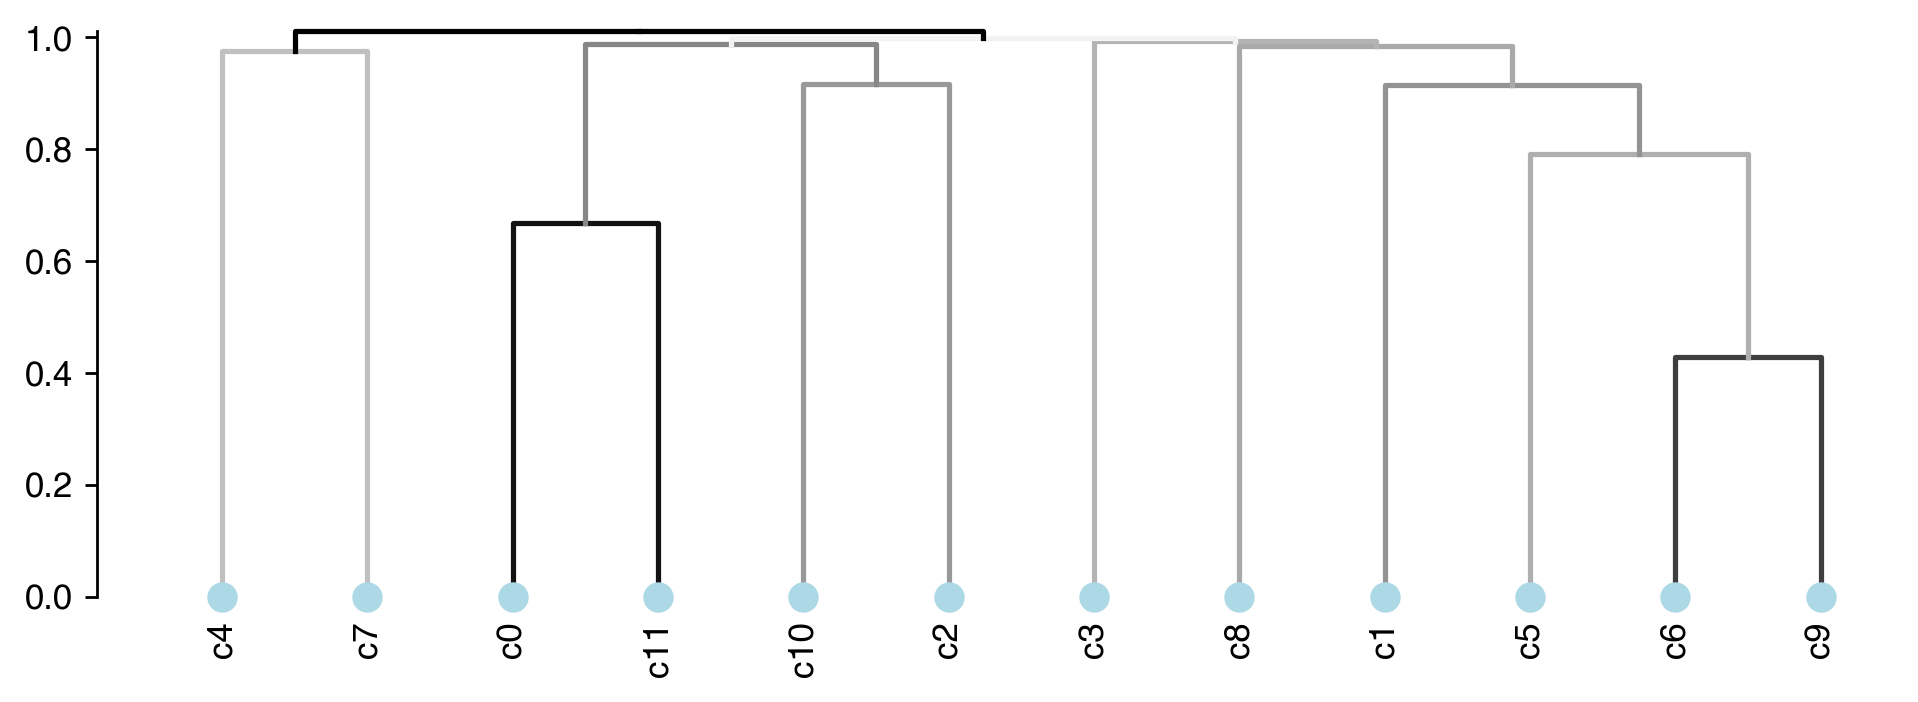

In [12]:
fig, ax = plt.subplots(figsize=(9, 3), dpi=250)
_ = plot_dendrogram(dendro=dendro.dendrogram,
                    linkage_df=dendro.linkage,
                    ax=ax,
                    plot_non_singleton=False,
                    line_hue=dendro.edge_stats['au'], # au is the branch confidence score, see pvclust documentation
                    line_hue_norm=(0.5, 1))

## Sanity Test

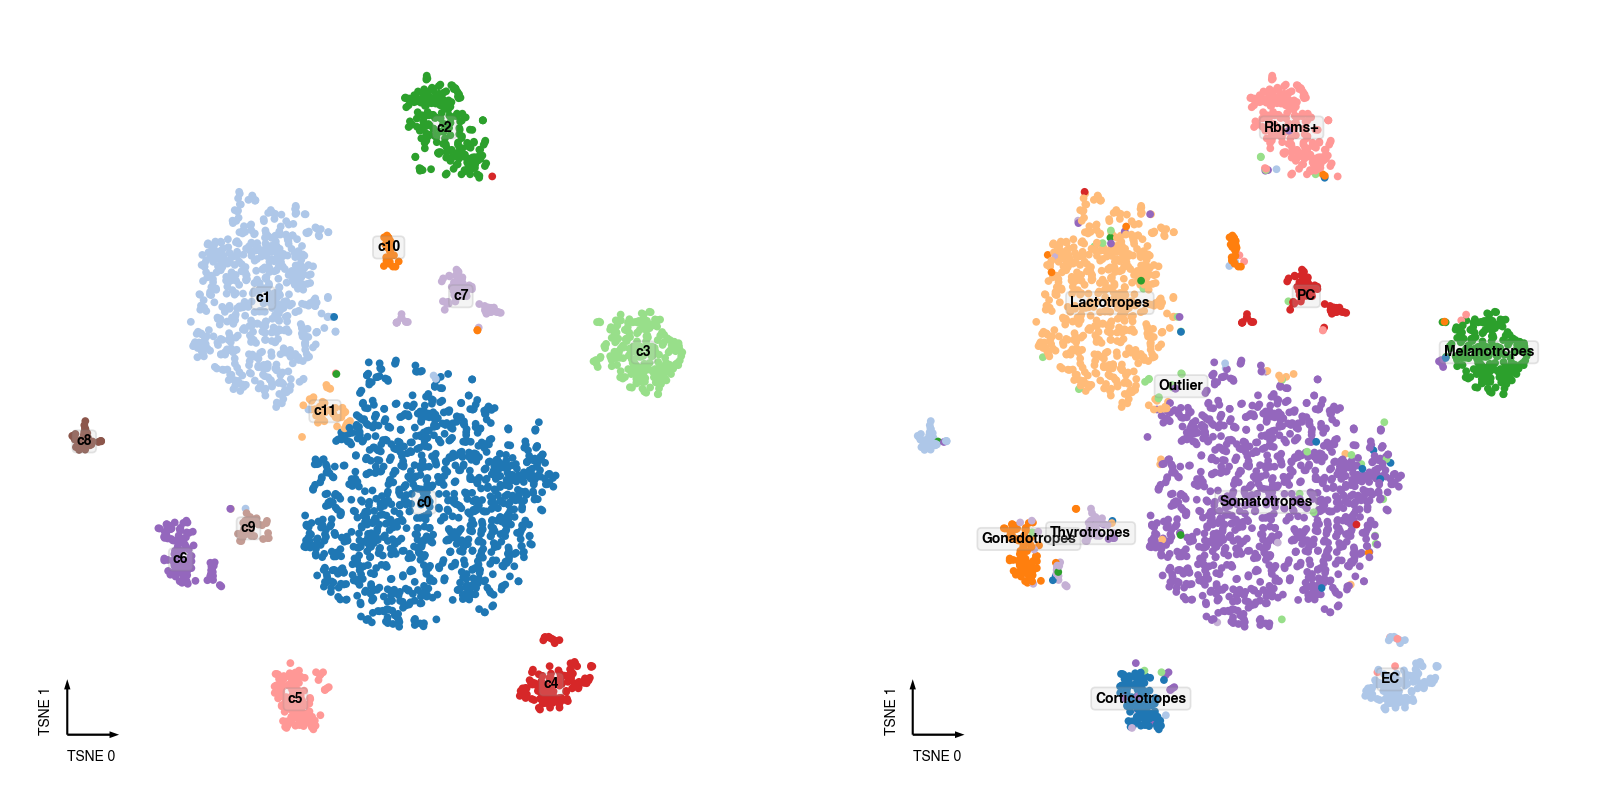

In [13]:
if 'CellTypeAnno' in cell_meta:
    fig, axes = plt.subplots(figsize=(8, 4), dpi=250, ncols=2)
    ax = axes[0]
    _ = categorical_scatter(data=adata.obs,
                            ax=ax,
                            hue=clustering_name,
                            coord_base=coord_base,
                            palette='tab20',
                            text_anno=clustering_name,
                            show_legend=False)
    ax = axes[1]
    adata.obs['CellTypeAnno'] = cell_meta['CellTypeAnno']
    _ = categorical_scatter(data=adata.obs.dropna(subset=['CellTypeAnno']),
                            ax=ax,
                            hue='CellTypeAnno',
                            coord_base=coord_base,
                            palette='tab20',
                            text_anno='CellTypeAnno',
                            show_legend=False)

## Save

In [14]:
cc.save(f'{clustering_name}.ConcensusClustering.model.lib')
dendro.save(f'{clustering_name}.Dendrogram.lib')
adata.write_h5ad(adata_path)

... storing 'CellTypeAnno' as categorical
... storing 'L1' as categorical


In [15]:
adata

AnnData object with n_obs × n_vars = 2756 × 388143
    obs: 'CellInputReadPairs', 'MappingRate', 'FinalmCReads', 'mCCCFrac', 'mCGFrac', 'mCHFrac', 'Plate', 'Col384', 'Row384', 'CellTypeAnno', 'leiden', 'tsne_0', 'tsne_1', 'umap_0', 'umap_1', 'L1', 'L1_proba'
    var: 'chrom', 'start', 'end'
    uns: 'leiden', 'leiden_sizes', 'neighbors', 'paga', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'